In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


METHOD 2

In [37]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve,auc,precision_recall_curve
import matplotlib.pyplot as plt
np.random.seed(42)

In [15]:
PATH = '/content/gdrive/MyDrive/Colab/datasets'

df_test = pd.read_csv(PATH + '/test_simulated.csv')
df_test.drop(['ID_code'], axis=1, inplace=True)
df_test = df_test.values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in range(df_test.shape[1]):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print('Found',len(real_samples_indexes),'real test')
print('Found',len(synthetic_samples_indexes),'fake test')


d = {}
for i in range(200): d['var_'+str(i)] = 'float32'
d['target'] = 'uint8'
d['ID_code'] = 'object'

# simple variance transform
train_2 = pd.read_csv(PATH + '/train_simulated.csv')
test_2 = pd.read_csv(PATH + '/test_simulated.csv')

ids = np.arange(test_2.shape[0])
real_ids = list(set(ids) - set(synthetic_samples_indexes))
real_test = test_2.iloc[real_ids]
fake_test = test_2.iloc[synthetic_samples_indexes]
real_test_id = real_test.ID_code
features = [c for c in train_2.columns if c not in ['target', 'ID_code']]
df = pd.concat([train_2,real_test], axis = 0)

# FE
for feat in features:
    df[feat+'_var'] = df.groupby([feat])[feat].transform('var')
    df[feat+'plus_'] = df[feat] + df[feat+'_var']
    #df[feat+"minus"] = df[feat] - df[feat+'_var']
    
drop_features = [c for c in df.columns if '_var' in c]
df.drop(drop_features, axis=1, inplace=True)

Found 40000 real test
Found 0 fake test


In [17]:
train = df.iloc[:train_2.shape[0]]
real_test = df.iloc[train_2.shape[0]:]

features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target'] 

print(train.shape)
print(real_test.shape)
print(len(features))

(160000, 402)
(40000, 402)
400


In [18]:
# shuffle func
def disarrange(a, axis=-1):
    """
    Shuffle `a` in-place along the given axis.
    Apply numpy.random.shuffle to the given axis of `a`.
    Each one-dimensional slice is shuffled independently.
    """
    b = a.swapaxes(axis, -1)
    # Shuffle `b` in-place along the last axis.  `b` is a view of `a`,
    # so `a` is shuffled in place, too.
    shp = b.shape[:-1]
    for ndx in np.ndindex(shp):
        np.random.shuffle(b[ndx])
    return

def augment_fast2(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        disarrange(x1,axis=0)
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        disarrange(x1,axis=0)
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [19]:
x = train[features]
y = train['target']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [20]:
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : 42,
    "verbosity" : 1,
    "seed": 42
}

X_t, y_t = augment_fast2(x_train.values, y_train.values)
X_t = pd.DataFrame(X_t)
X_t = X_t.add_prefix('var_')
    
trn_data = lgb.Dataset(X_t, label=y_t)
val_data = lgb.Dataset(x_test, label=y_test)
evals_result = {}
lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=3000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )

Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.924526	valid_1's auc: 0.877858
[2000]	training's auc: 0.938207	valid_1's auc: 0.89056
[3000]	training's auc: 0.947508	valid_1's auc: 0.899928
[4000]	training's auc: 0.953301	valid_1's auc: 0.9053
[5000]	training's auc: 0.957293	valid_1's auc: 0.908748
[6000]	training's auc: 0.960208	valid_1's auc: 0.910716
[7000]	training's auc: 0.962576	valid_1's auc: 0.911998
[8000]	training's auc: 0.964614	valid_1's auc: 0.912815
[9000]	training's auc: 0.966438	valid_1's auc: 0.913401
[10000]	training's auc: 0.968187	valid_1's auc: 0.913769
[11000]	training's auc: 0.969847	valid_1's auc: 0.914068
[12000]	training's auc: 0.971439	valid_1's auc: 0.914145
[13000]	training's auc: 0.97293	valid_1's auc: 0.914268
[14000]	training's auc: 0.974393	valid_1's auc: 0.914218
[15000]	training's auc: 0.975813	valid_1's auc: 0.914139
[16000]	training's auc: 0.97718	valid_1's auc: 0.914093
Early stopping, best iteration is:
[13

In [53]:
def Evaluation(model,test_X,test_Y,fp_cost,fn_cost):
    prob=model.predict(test_X)
    fpr,tpr,threshold=roc_curve(test_Y,prob)
    roc_auc=auc(fpr,tpr)
    results=pd.DataFrame({'Actual_Value':list(test_Y),'Probability':list(prob)}).sort_values('Probability',ascending=False)
    results['num']=np.arange(len(test_Y))+1
    results['pct']=(np.arange(len(test_Y))+1)/len(test_Y)
    results['threshold']= results['num']/len(test_Y)
    results['TP'] = results['Actual_Value'].cumsum()
    results['FP'] = results['num']-results['TP']
    results['TN']= (len(test_Y) - results['num'])-(sum(results['Actual_Value'])-results['TP'])
    results['FN']= sum(results['Actual_Value'])-results['TP']
    results['tpr']= results['TP']/sum(results['Actual_Value'])
    results['fpr']= results['FP']/(len(test_Y)-sum(results['Actual_Value']))
    results['precision']=results['TP']/results['num']
    results['recall']=results['TP']/(results['TP']+results['FN'])
    results['f']=2*results['precision']*results['recall']/(results['recall']+results['precision'])
    results['lift']=results['precision']/(sum(results['Actual_Value'])/len(test_Y))
    results['accuracy']=(results['TP']+results['TN'])/len(test_Y)
    results['fp_cost']=results['FP']*fp_cost
    results['fn_cost']=results['FN']*fn_cost
    results['total_cost']=(results['fp_cost']+results['fn_cost'])/len(test_Y)
    df=results[results['total_cost']==results['total_cost'].min()][['threshold','accuracy','precision','recall','f','total_cost']]
    print(df.iloc[0,:])
    #Plot ROC Curve
    plt.figure(figsize=[10,5])
    plt.plot(results['threshold'],results['total_cost'],'g--')
    plt.title('Cost Curve',fontsize=30)
    plt.show() 
    df_2 = results[results['total_cost']==results['total_cost'].min()]
    return df_2.iloc[0,:]

In [41]:
df_test = pd.read_csv(PATH + '/test_simulated.csv')

In [ ]:
"""
According to a survey conducted by Parvathy P (2017), it costs a bank around $80 to acquire a credict card customer who returns about $120 in profit.  
We will use 80 as false positive cost (Cost of mis-classifying a customer that will never make a transaction as a potential customer)
We will use 120 as false negative cost (Cost of mis-classifying a potential customer)
"""

threshold     0.075950
accuracy      0.929625
precision     0.710994
recall        0.527215
f             0.605466
total_cost    7.567000
Name: 4838, dtype: float64


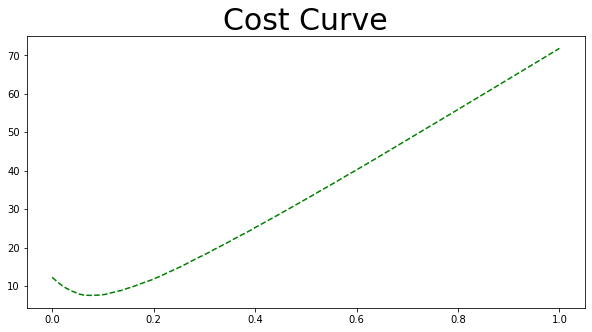

Actual_Value         1.000000
Probability          0.465981
num               3038.000000
pct                  0.075950
threshold            0.075950
TP                2160.000000
FP                 878.000000
TN               35025.000000
FN                1937.000000
tpr                  0.527215
fpr                  0.024455
precision            0.710994
recall               0.527215
f                    0.605466
lift                 6.941607
accuracy             0.929625
fp_cost          70240.000000
fn_cost         232440.000000
total_cost           7.567000
Name: 4838, dtype: float64

In [54]:
test_y = df_test['target']
fp_cost = 80
fn_cost = 120
Evaluation(lgb_clf,test_3,test_y.values,fp_cost,fn_cost)

threshold     0.075950
accuracy      0.929625
precision     0.710994
recall        0.527215
f             0.605466
total_cost    7.567000
Name: 4838, dtype: float64


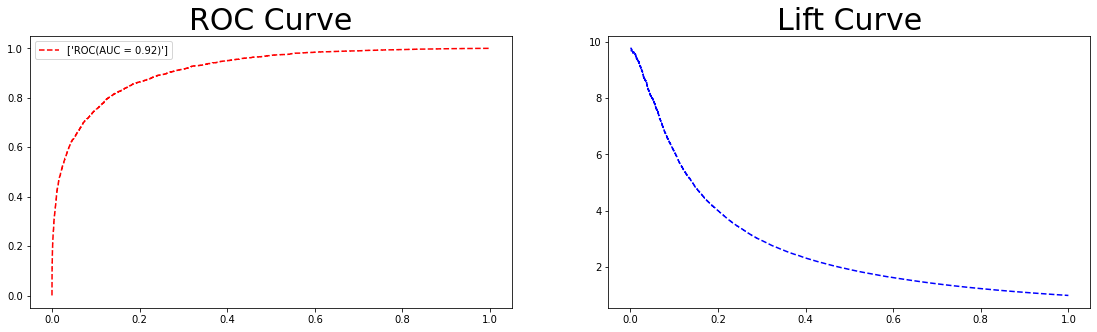

Actual_Value         1.000000
Probability          0.465981
num               3038.000000
pct                  0.075950
threshold            0.075950
TP                2160.000000
FP                 878.000000
TN               35025.000000
FN                1937.000000
tpr                  0.527215
fpr                  0.024455
precision            0.710994
recall               0.527215
f                    0.605466
lift                 6.941607
accuracy             0.929625
fp_cost          70240.000000
fn_cost         232440.000000
total_cost           7.567000
Name: 4838, dtype: float64

In [59]:
def Evaluation(model,test_X,test_Y,fp_cost,fn_cost):
    prob=model.predict(test_X)
    fpr,tpr,threshold=roc_curve(test_Y,prob)
    roc_auc=auc(fpr,tpr)
    results=pd.DataFrame({'Actual_Value':list(test_Y),'Probability':list(prob)}).sort_values('Probability',ascending=False)
    results['num']=np.arange(len(test_Y))+1
    results['pct']=(np.arange(len(test_Y))+1)/len(test_Y)
    results['threshold']= results['num']/len(test_Y)
    results['TP'] = results['Actual_Value'].cumsum()
    results['FP'] = results['num']-results['TP']
    results['TN']= (len(test_Y) - results['num'])-(sum(results['Actual_Value'])-results['TP'])
    results['FN']= sum(results['Actual_Value'])-results['TP']
    results['tpr']= results['TP']/sum(results['Actual_Value'])
    results['fpr']= results['FP']/(len(test_Y)-sum(results['Actual_Value']))
    results['precision']=results['TP']/results['num']
    results['recall']=results['TP']/(results['TP']+results['FN'])
    results['f']=2*results['precision']*results['recall']/(results['recall']+results['precision'])
    results['lift']=results['precision']/(sum(results['Actual_Value'])/len(test_Y))
    results['accuracy']=(results['TP']+results['TN'])/len(test_Y)
    results['fp_cost']=results['FP']*fp_cost
    results['fn_cost']=results['FN']*fn_cost
    results['total_cost']=(results['fp_cost']+results['fn_cost'])/len(test_Y)
    df=results[results['total_cost']==results['total_cost'].min()][['threshold','accuracy','precision','recall','f','total_cost']]
    print(df.iloc[0,:])
    #Plot ROC Curve
    plt.figure(figsize=[19,5])
    plt.subplot(1,2,1)
    plt.plot(results['fpr'],results['tpr'],'r--',label=['ROC(AUC = %0.2f)'%roc_auc])
    plt.legend()
    plt.title('ROC Curve',fontsize=30)
    plt.subplot(1,2,2)
    plt.plot(results['pct'],results['lift'],'b--')
    plt.title('Lift Curve',fontsize=30)
    plt.show() 
    df_2 = results[results['total_cost']==results['total_cost'].min()]
    return df_2.iloc[0,:]
test_y = df_test['target']
fp_cost = 80
fn_cost = 120
Evaluation(lgb_clf,test_3,test_y.values,fp_cost,fn_cost)